In [1]:
import numpy as np
# import pandas as pd
import tensorflow as tf
from pykrx import stock
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler


# 종목 코드와 날짜 설정
stock_code = "005930"  # 삼성전자 예시
end_date = datetime.today().strftime("%Y%m%d")
start_date = (datetime.today() - timedelta(days=365)).strftime("%Y%m%d")

# OHLCV 데이터 가져오기
ohlcv = stock.get_market_ohlcv_by_date(fromdate=start_date, todate=end_date, ticker=stock_code)

# 펀더멘털 지표 가져오기
fundamental = stock.get_market_fundamental_by_date(fromdate=start_date, todate=end_date, ticker=stock_code)

# 데이터 준비
data = ohlcv['종가'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


# LSTM에 입력할 데이터 형태로 변환
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)


look_back = 5
X, Y = create_dataset(scaled_data, look_back)

# 훈련 데이터와 테스트 데이터 분리 (예: 최근 20% 데이터를 테스트 데이터로 사용)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
trainX, testX = X[0:train_size], X[train_size:len(X)]
trainY, testY = Y[0:train_size], Y[train_size:len(Y)]

# LSTM 모델 구성 및 학습
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# 내일부터 일주일간 주가 예측
to_predict = scaled_data[-look_back:]
print(to_predict)
predicted_price = model.predict(np.array([to_predict]))
predicted_price = scaler.inverse_transform(predicted_price)  # 예측된 값을 원래 스케일로 변환

print("예측된 가격:", predicted_price)



Epoch 1/100
192/192 - 2s - loss: 0.0214 - 2s/epoch - 13ms/step
Epoch 2/100
192/192 - 0s - loss: 0.0059 - 373ms/epoch - 2ms/step
Epoch 3/100
192/192 - 0s - loss: 0.0053 - 372ms/epoch - 2ms/step
Epoch 4/100
192/192 - 0s - loss: 0.0050 - 375ms/epoch - 2ms/step
Epoch 5/100
192/192 - 0s - loss: 0.0054 - 368ms/epoch - 2ms/step
Epoch 6/100
192/192 - 0s - loss: 0.0048 - 383ms/epoch - 2ms/step
Epoch 7/100
192/192 - 0s - loss: 0.0052 - 370ms/epoch - 2ms/step
Epoch 8/100
192/192 - 0s - loss: 0.0050 - 375ms/epoch - 2ms/step
Epoch 9/100
192/192 - 0s - loss: 0.0045 - 376ms/epoch - 2ms/step
Epoch 10/100
192/192 - 0s - loss: 0.0041 - 373ms/epoch - 2ms/step
Epoch 11/100
192/192 - 0s - loss: 0.0042 - 381ms/epoch - 2ms/step
Epoch 12/100
192/192 - 0s - loss: 0.0042 - 378ms/epoch - 2ms/step
Epoch 13/100
192/192 - 0s - loss: 0.0041 - 393ms/epoch - 2ms/step
Epoch 14/100
192/192 - 0s - loss: 0.0038 - 367ms/epoch - 2ms/step
Epoch 15/100
192/192 - 0s - loss: 0.0036 - 360ms/epoch - 2ms/step
Epoch 16/100
192/192 

In [2]:
# 내일부터 일주일간 주가 예측
to_predict = scaled_data[-look_back:]
print(to_predict)
print(trainX)
predicted_price = model.predict(np.array([to_predict]))
predicted_price = scaler.inverse_transform(predicted_price)  # 예측된 값을 원래 스케일로 변환

print("예측된 가격:", predicted_price)

[[0.85436893]
 [0.87864078]
 [0.94660194]
 [0.95631068]
 [1.        ]]
[[0.13592233 0.12621359 0.13592233 0.0631068  0.        ]
 [0.12621359 0.13592233 0.0631068  0.         0.00970874]
 [0.13592233 0.0631068  0.         0.00970874 0.00485437]
 [0.0631068  0.         0.00970874 0.00485437 0.12135922]
 [0.         0.00970874 0.00485437 0.12135922 0.1407767 ]
 [0.00970874 0.00485437 0.12135922 0.1407767  0.17961165]
 [0.00485437 0.12135922 0.1407767  0.17961165 0.26213592]
 [0.12135922 0.1407767  0.17961165 0.26213592 0.24757282]
 [0.1407767  0.17961165 0.26213592 0.24757282 0.25242718]
 [0.17961165 0.26213592 0.24757282 0.25242718 0.25242718]
 [0.26213592 0.24757282 0.25242718 0.25242718 0.26699029]
 [0.24757282 0.25242718 0.25242718 0.26699029 0.2815534 ]
 [0.25242718 0.25242718 0.26699029 0.2815534  0.27669903]
 [0.25242718 0.26699029 0.2815534  0.27669903 0.24757282]
 [0.26699029 0.2815534  0.27669903 0.24757282 0.30097087]
 [0.2815534  0.27669903 0.24757282 0.30097087 0.31553398]
 

In [3]:
# 실제 가격과 예측 가격 비교를 위한 데이터 준비
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)
trainY = scaler.inverse_transform([trainY])
testY = scaler.inverse_transform([testY])

# 시각화
plt.plot(data, label='Actual Price')
plt.plot(np.append(trainPredict, testPredict), label='Predicted Price')
plt.legend()
plt.show()

TypeError: in user code:

    File "c:\Users\forev\anaconda3\envs\strike_it_rich\lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\forev\anaconda3\envs\strike_it_rich\lib\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\forev\anaconda3\envs\strike_it_rich\lib\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\forev\anaconda3\envs\strike_it_rich\lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "c:\Users\forev\anaconda3\envs\strike_it_rich\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\forev\anaconda3\envs\strike_it_rich\lib\site-packages\keras\src\layers\rnn\lstm.py", line 616, in call
        timesteps = input_shape[0] if self.time_major else input_shape[1]

    TypeError: Exception encountered when calling layer 'lstm' (type LSTM).
    
    'NoneType' object is not subscriptable
    
    Call arguments received by layer 'lstm' (type LSTM):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • mask=None
      • training=False
      • initial_state=None


In [7]:
from pykrx import stock
import pandas as pd
from datetime import datetime, timedelta

# 삼성전자 종목 코드
stock_code = "033780"

# 날짜 설정
end_date = datetime.today().strftime("%Y%m%d")
start_date = (datetime.today() - timedelta(days=365)).strftime("%Y%m%d")

# OHLCV 데이터 가져오기
ohlcv = stock.get_market_ohlcv_by_date(start_date, end_date, stock_code)

# 펀더멘털 데이터 가져오기
fundamental = stock.get_market_fundamental_by_date(start_date, end_date, stock_code)


In [10]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_price = scaler.fit_transform(ohlcv['종가'].values.reshape(-1, 1))

# 시퀀스 데이터 준비
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 5
X, _ = create_dataset(scaled_close_price, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# LSTM 모델 구축
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# 여기서는 가중치를 미리 학습하지 않았으므로, 실제 예측 정확도는 제한적일 수 있습니다.

# 예측
predicted_prices = model.predict(X)
predicted_prices = scaler.inverse_transform(predicted_prices)


Epoch 1/100
192/192 - 2s - loss: 0.0225 - 2s/epoch - 13ms/step
Epoch 2/100
192/192 - 0s - loss: 0.0053 - 365ms/epoch - 2ms/step
Epoch 3/100
192/192 - 0s - loss: 0.0062 - 374ms/epoch - 2ms/step
Epoch 4/100
192/192 - 0s - loss: 0.0052 - 366ms/epoch - 2ms/step
Epoch 5/100
192/192 - 0s - loss: 0.0052 - 365ms/epoch - 2ms/step
Epoch 6/100
192/192 - 0s - loss: 0.0050 - 368ms/epoch - 2ms/step
Epoch 7/100
192/192 - 0s - loss: 0.0046 - 391ms/epoch - 2ms/step
Epoch 8/100
192/192 - 0s - loss: 0.0044 - 409ms/epoch - 2ms/step
Epoch 9/100
192/192 - 0s - loss: 0.0047 - 433ms/epoch - 2ms/step
Epoch 10/100
192/192 - 0s - loss: 0.0044 - 405ms/epoch - 2ms/step
Epoch 11/100
192/192 - 0s - loss: 0.0058 - 400ms/epoch - 2ms/step
Epoch 12/100
192/192 - 0s - loss: 0.0039 - 388ms/epoch - 2ms/step
Epoch 13/100
192/192 - 0s - loss: 0.0040 - 375ms/epoch - 2ms/step
Epoch 14/100
192/192 - 0s - loss: 0.0045 - 387ms/epoch - 2ms/step
Epoch 15/100
192/192 - 0s - loss: 0.0034 - 403ms/epoch - 2ms/step
Epoch 16/100
192/192 

In [12]:


# 내일부터 일주일간 주가 예측
to_predict = scaled_data[-look_back:]
print(to_predict)
predicted_price = model.predict(np.array([to_predict]))
predicted_price = scaler.inverse_transform(predicted_price)  # 예측된 값을 원래 스케일로 변환

print("예측된 가격:", predicted_price)


[[0.85436893]
 [0.87864078]
 [0.94660194]
 [0.95631068]
 [1.        ]]
1/1 [==============================] - 0s 16ms/step
예측된 가격: [[95413.195]]


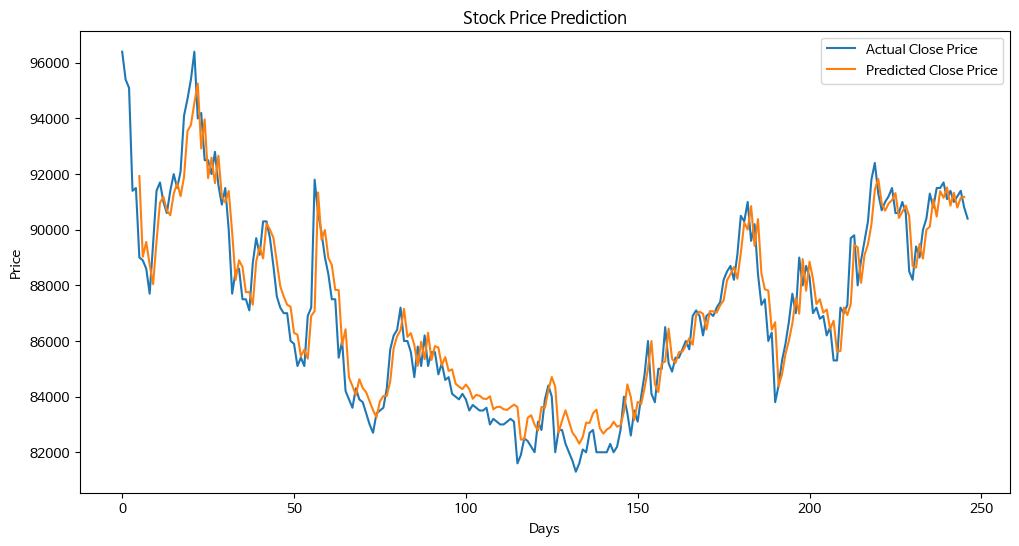

In [11]:
import matplotlib.pyplot as plt

# 실제 종가 및 예측된 종가 그래프로 시각화
plt.figure(figsize=(12, 6))
plt.plot(ohlcv['종가'].values, label='Actual Close Price')
plt.plot(range(look_back, len(predicted_prices) + look_back), predicted_prices.ravel(), label='Predicted Close Price')
plt.title('Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()
